# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. You wil have to create your own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [108]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding thee obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```. 

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
   $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.

3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.
   
## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller. Make sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$



Please submit your code (as runnable Jupyter Notebook), a pdf report and an mp4 video. In the report, explain your reward design and provide plots showing the trajectory of the quadrotor. The mp4 video should show the quadrotor animation starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$. You can save your animation in the following way:


In [143]:
import numpy as np
import gymnasium
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import quadrotor
import matplotlib.pyplot as plt

In [151]:
class QuadrotorEnv(gym.Env):
    def __init__(self):
        super().__init__()
        
        # State/action spaces
        state_low = np.array([-4, -10, -4, -10, -2*np.pi, -10])
        state_high = np.array([4, 10, 4, 10, 2*np.pi, 10]) 
        self.observation_space = spaces.Box(state_low, state_high, dtype=np.float32)
        self.action_space = spaces.Box(-np.ones(2), np.ones(2), dtype=np.float32)
        
        # Environment setup
        self.target = np.array([2, 0, 0, 0, 0, 0], dtype=np.float32)
        self.max_steps = 200
        self.reset()
        
    def step(self, action):
        self.current_step += 1
        
        # Control with gravity compensation
        u = (action + 1) * (quadrotor.MASS * quadrotor.GRAVITY_CONSTANT / 2)
        self.state = np.array(quadrotor.next_state(self.state, u), dtype=np.float32)
        
        # Compute rewards/penalties
        reward = self._get_reward()
        done = self._is_done()
        truncated = self.current_step >= self.max_steps
        
        return self.state, reward, done, truncated, {}
    
    def reset(self, seed=None, options=None):
        if seed:
            np.random.seed(seed)
            
        self.current_step = 0
        self.state = self._get_valid_state()
        return self.state, {}
        
    def _get_reward(self):
        # Distance reward with state and control costs
        Q = np.eye(6, dtype=np.float32)
        state_diff = self.state - self.target
        reward = np.exp(-0.5 * state_diff @ Q @ state_diff)
        
        # penalties
        if quadrotor.check_collision(self.state):
            reward -= 1.0
        if self._is_out_of_bounds():
            reward -= 100.0
            
        return float(reward)
    
    def _get_valid_state(self):
        while True:
            state = np.array([
                np.random.uniform(-2, 2), 0,  
                np.random.uniform(-2, 2), 0,  
                0, 0                          
            ], dtype=np.float32)
            if not quadrotor.check_collision(state):
                return state
                
    def _is_out_of_bounds(self):
        bounds = np.array([
            [-4, 4], [-10, 10],     
            [-4, 4], [-10, 10],    
            [-2*np.pi, 2*np.pi],    
            [-10, 10]               
        ])
        return np.any((self.state < bounds[:,0]) | (self.state > bounds[:,1]))
        
    def _is_done(self):
        return self._is_out_of_bounds() or quadrotor.check_collision(self.state)

In [152]:
def train_quadrotor(total_steps=1000000):
    env = QuadrotorEnv()
    
    # Custom network architecture
    policy_kwargs = dict(
        net_arch=dict(
            pi=[128, 128, 64],  # Policy network
            vf=[128, 128, 64]   # Value function network
        )
    )
    
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        policy_kwargs=policy_kwargs,
        learning_rate=1e-3,
        n_steps=1024,
        batch_size=128,
        n_epochs=8,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01
    )
    
    model.learn(
        total_timesteps=total_steps,
        progress_bar=True
    )
    return model

def evaluate_policy(model, env, episodes=5):
    rewards = []
    trajectories = []
    
    for ep in range(episodes):
        obs, _ = env.reset()
        ep_rewards = 0
        states = []
        
        while True:
            states.append(obs)
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, term, trunc, _ = env.step(action)
            ep_rewards += reward
            
            if term or trunc:
                break
                
        rewards.append(ep_rewards)
        trajectories.append(np.array(states))
        
        # Visualization
        plt.figure(figsize=(8, 6))
        states = np.array(states)
        plt.plot(states[:, 0], states[:, 2], 'b-', label='Trajectory')
        plt.plot(2, 0, 'r*', markersize=15, label='Target')
        
        # Plot obstacles
        for center in quadrotor.OBSTACLE_CENTERS:
            circle = plt.Circle(center, quadrotor.OBSTACLE_RADIUS, color='gray', alpha=0.3)
            plt.gca().add_patch(circle)
            
        plt.title(f'Episode {ep+1} - Reward: {ep_rewards:.1f}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.legend()
        plt.axis('equal')
        plt.show()
        
    return np.mean(rewards), trajectories

def generate_animation(model, save_path='quadrotor.mp4'):
    def policy_controller(state, t):
        action, _ = model.predict(state, deterministic=True)
        u_grav = quadrotor.MASS * quadrotor.GRAVITY_CONSTANT / 2
        return (action + 1) * u_grav
    
    start_state = np.array([-2, 0, 0, 0, 0, 0])
    sim_horizon = 200
    
    _, states, controls = quadrotor.simulate(
        start_state, 
        policy_controller, 
        sim_horizon
    )
    
    quadrotor.animate_robot(states, controls, dt=quadrotor.DT,save_mp4=True)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.4     |
|    ep_rew_mean     | -48.8    |
| time/              |          |
|    fps             | 6735     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.5        |
|    ep_rew_mean          | -47.8       |
| time/                   |             |
|    fps                  | 4923        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004907312 |
|    clip_fraction        | 0.0291      |
|    clip_range           | 0.2         |
|    entropy_loss   

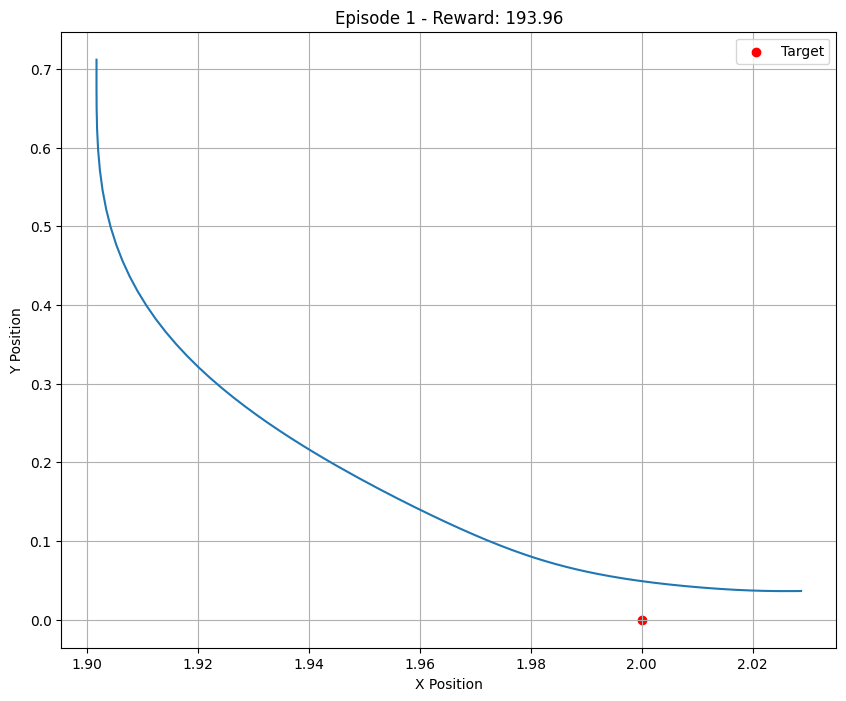

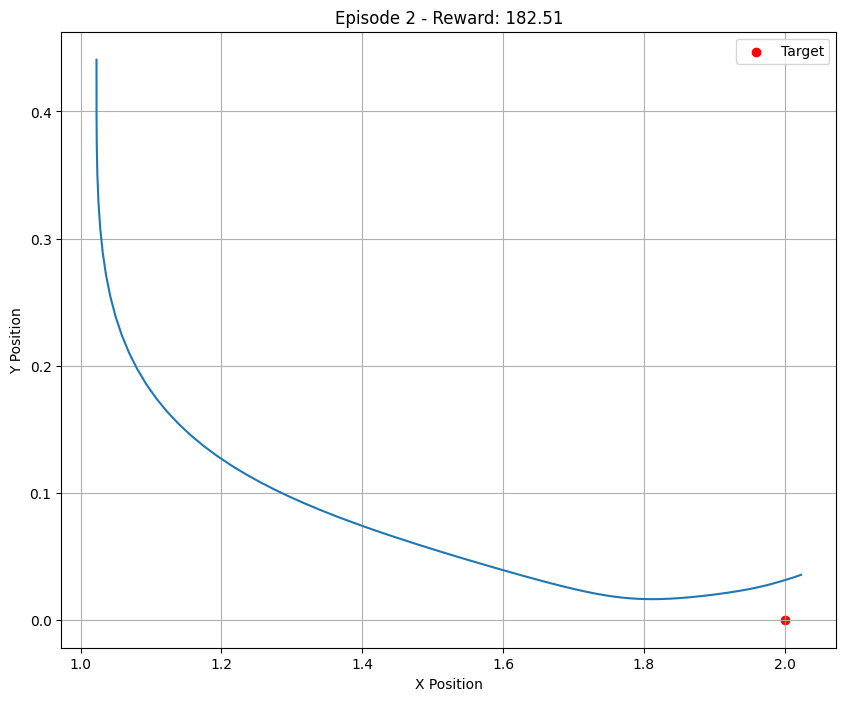

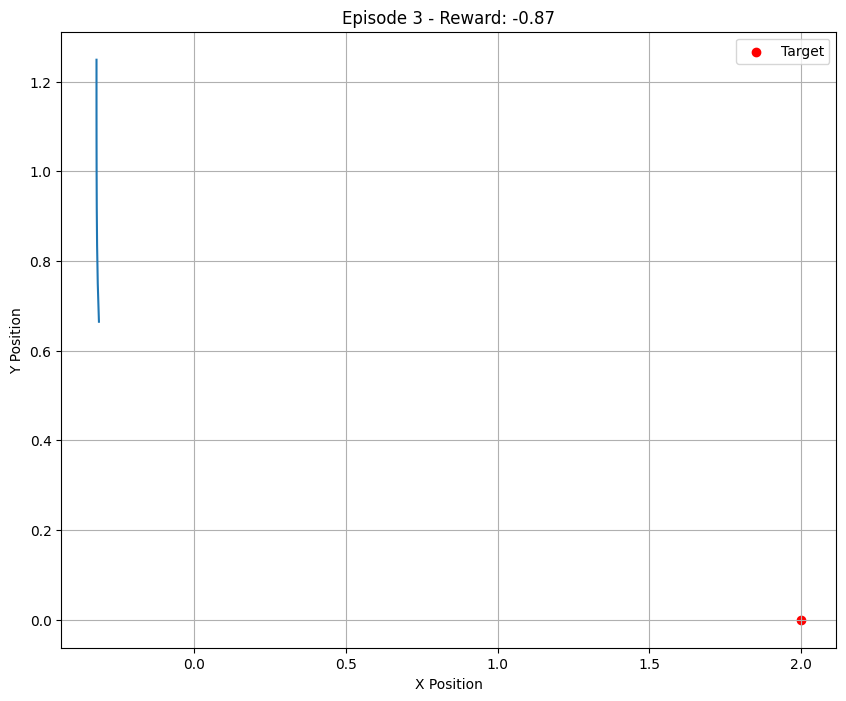

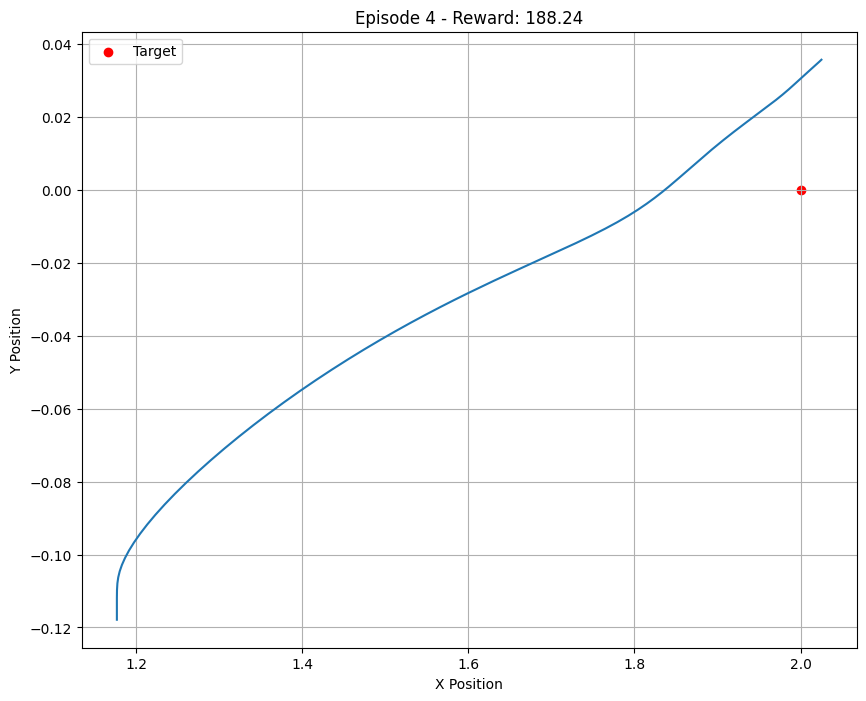

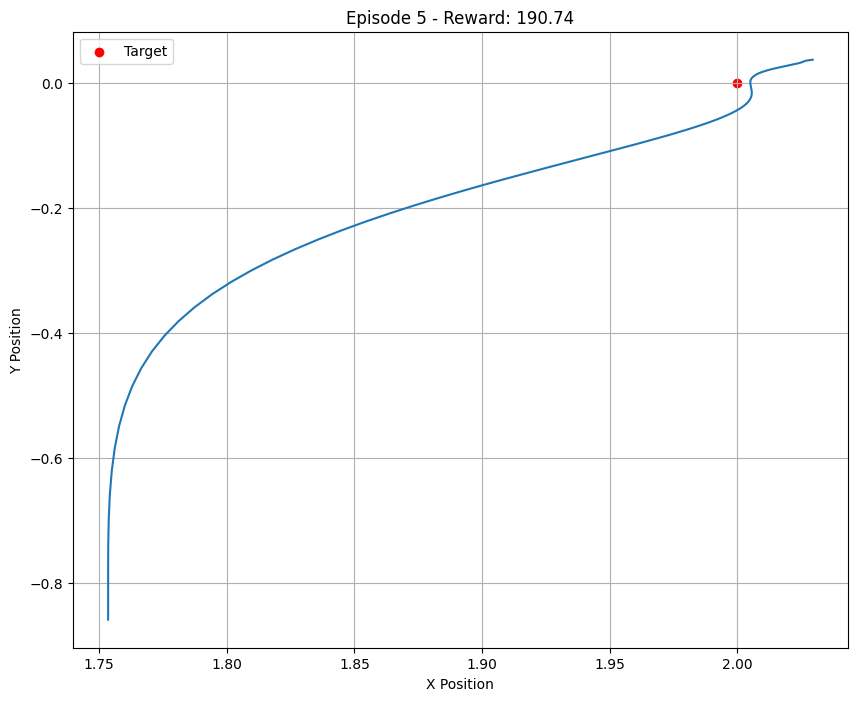

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAg0ttZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GiFliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3umtv+o/J6/ws88Qe3ONgU
Wqn7AorM+LAmktu93aN6yZPklWjHNpAwxKdlCEwKd91/J8626QouDenqpZPv7ahuvKusiJK/OJi2
r3G+LRHdO9GtG/WbE45EQNeR/mC7hVAkLxwyFrXupOJM3weGKtVV3t8nHj2ru0Y/bR2kTdViezf9
WfdBp9+TxCTjQrzvtriAkIoaJtHQX5yUpRTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOYO2BN2gf1
Hx7VV5QkudM2W5WhNcyFXMMOVfKEA32BXDqBcJctX9RJORWCS/OZGLwi7m98w5ZqoIaAtKYW+9F7
zuUSe0lm6gTaoEF2GZ9pMuF7De1uSi0Qd4Wa/+X5Jyc/TuQ3tfAcRZiMNzOx5j9zi9JNFH3knnT+
CCt+0GGJaG59ZY9mwxh87IhL+OdxucIjR6IDTKGVU+2f7L3EwjW5zM/KYi7l3yomwouFofGIg32f
CUDBb4E9IWwFAAeYfaVEunEPoeLviZB2VKZ8GGOmPkcgnVRpfYW5AQAAEUzf8F5sWXiGVsnKrsgP
kdvCLamdOiDHf4DtYYXq6kvVYV6nUJ8RB2/y45HIengt3PNCzotT3Jr/X4ZqdXQgQ+28gAiJ6838
ieT7IDF5FwqW406IYRLrCsh9ZVKCYkK08fk6tARsesDL6Tkkg9IwHjlm3Glvdjdv6XSv1Kf9DeOm
8genofy3v2S8+rnwDNk9Yy3SIetNAfucB3QXfJxytuP3Y5k6YnEgNP5DriegvLFPUht998ptlir/
u6qPiERM9mTwqadJYrpig6qqgAAOcP8IqV9ouQMOzHzfFHUQHm1neSESTXulV1tvaFyDi38tbuT+
G6iedrUwQCX6mRjsqi2MQj5AkAwrdtNvzB9sQCTGSSXsboB2+paGEYsgx8boe3aE1VbunMrTFpLS
arQ8GzTTG4cLC6zvqxjlB/fRpzWTTwRV/d9Mu03MTnRLKwWYBZqOVgZUmJVLK1W48CfUIqtoqiDT
qhyAnREwnbktpnlQbxqqKl1jopAL900WKl1MMoAGpFsdpTaPiYaYQwtr9luwWwvH6mn/Mvewl2zQ
pvd24f8Pvhr02TY+YIxsB43x5cFzYj3EO3yGji2R4zxSKxlWXOmjcURgrSPZaVM7f2iSC2S0Z+Qi
bolI/hylauX3EDfuB1SFXygpVro/qyDU080LNf85HoI96WHy1BC1iBsWbu/wVy88OUZPZlePvOpB
qqEWXwAwzef67uA+XiLWcJsuyRe1oRKgwb2tJJvNWUyayzHlttDz+9sPxEo/oFV308cIm2nVDSmG
3PWJyYQWBeLs/Y6yQQLFEqSofOAIVtgntlBSL7TuPVqjmDGzL1fHPqiBeK5Fi+lTCi1BCEWVI5B8
erNE63GBP6AXlb8GCdprnuNko+LJ6uCHQE3Km0OdZvIwfULNAF8Tjj7D2wqc1R9W8TsREMLtcOQN
vfGiKJCuPwId2O8E14gsqVEzPglXTqzZc6GftNG/dcptXLvpgH2aR2S4ZHoltJWcVYCDql9ehqJ3
MSuoiWrj0rT9sMygKUKVbKptQytLshs2DvuyorgOMuOd1t5s5FwSZK4H6Q9iqiY91rwUrwhQALsE
+eIQOfFpa5xP8rT+pACm4VG/mpnEawFuhoYvGqDRYfUnqLttxYI4RC2yhVrFST1GH5cclfR2VY74
aBaEkVb7OgCcnRlRX/ZUUpxtjamszCb9qH5g9brE1ch4jxVmcQl0bZ2yVMiq1ZtFG7F0133VcSyP
b/JvI4HQpT9e2opIUkAvnhjYhcmnBWE3CAfVfefUzz46pdO2WTs/lXpxY+uSgVDkHS5pr2U259uC
xv/B2dkL2T5xECtPlUrpENSwzyj5MIYpB52Mcqm3poeLtqy1e4cybDJBi/9NnJdxIxtxhOAL3OrP
WLyQM35kJiMChL+FAABFgPfYjdi4NMKvgAQKBKyZcYh9fS9Ea8mjYOwBXWp6xFTpt8dyTB+T524a
8fFvvQuK6aNXpqfKteZojuhhe49Mr5BtJQef3NTLBl4ahg9WRS49fgl0ZcxRTiYs5+WSfsUjtof4
uvPKiPVtnhFZ1XkqdoXOiFEFSeAMOMGTWp5NTHfHZlxh/faHjB6lzmkFgrI8cynsjjGapuVfpT77
VN9+0l7hDauMMxaoQMY4ZXZaKiQ2aUBEeDmVYyvPbv33uCmEgqxrbaxihEIFbQYSyvDznckUcDEY
AIgUWZAcTXV+Eoukp2zl3IG1Bb/UyI2PEiScZt1UiUqQB6khefqikOhkH0THzvRGX6vBhEvptpzv
/o6s9hug8si4tHm7g+4xuLTdX+lt+/nZMB7DIdE2gyxsCWUc6FEEnNTqn/OJhJrY9rrkBO6NsGFo
Vu5LLScSzkr//3eZWJL5WnhBZ3YUKLHJHt1ov8uTUl5TRATeAAADAJwA3B2xULaABerjujXwAMjP
Cqnj/ZC5mARh/MUaLDtka

In [150]:
if __name__ == "__main__":
    # Train the model
    model = train_quadrotor()
    
    # environment for evaluation
    env = QuadrotorEnv()
    
    # Evaluate the trained policy
    evaluate_policy(model, env)
    
    # Generate and save animation
    generate_animation(model)

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython


def controller(x, t):
    return np.zeros(2)

x_init = np.array([-2, 0, 0., 0 ,0, 0])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAASWJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GiJliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmqAKw3p8+/i/wJs8O+8pdk8P
HVf783TzYB8jTD3e0Hrvk+m9yV30qkBMD1Yt4BTv0v5PnW3SFFwb09VLJ9/bXt1O+1kRJX5xMW1e
bcxaI7p3o1o16zYnHIiBryP8xbcKoEheOGQta91Jwpm+DwxVqqu9he48e1d2jH7aO0yXqsT2b/qz
7oLLlMh42Npded9tcQEhFDRNo5nfOSlKKeMLR8VskNKSA1Xup+D3KKP/Ucrk7dfblkrlCV0OT9R8
e1VeUJLnSiEnVqg5IfgEg1c+fw2G5gVw6gXCXLWJHWwLr7Zv9ubJ4/o4TKWpJu/d/99C6V3hQlL2
dlAntVuqdmAD3B0j6kW79UlFofjws1/8vyTk5+XWigBqqZX44ebKxHmP3OL0k0UfeSfDOZ+P0xnA
MS0Nz6yx3NhjD52RCX8aAvsAWIQQMqYvxcvcTCNbnLx8piLuXeNtrcp36rh1Mqz7PhKBiVgCkoe7
AP9TFTR0BGZ/D1cdBO83QAs0kqTjhk1oWhee5U2ZsL9uX343+EM2LLyd4BX9xHjeJfWQ6Z7ezogx
3+TeCvXrSblDJjbAaN/iIL4/CBV6HZLpVc80LOi1PXXp/r8M01VBIKfbeQARE9bL+Sy2S0BhyqRQ
Qpe1EL6xKWhDNZrpwd1cJgyGC10oKR6wMLcqBkxiXAcfyTKZPcwd2/pdK/Up6eN46byB6eh/AxyG
eNXPgyepR7S3jOi2dwAc8JnqoueT/CRHmHE50xOJAafyHV09BeWKepHBfDZo7loWoPVYZft6dyUK
BCZ0zHzOeJv/Qtw8gQnQSvhcrvRiqR58UdRAebWcct0k152VdbNffOhv7LlY89HDdRPRTyCZuhP1
NqbFQjh83FOIPjL22RZFj9Sm0uxTHPyMeOnzUYOiMGIH+NJL8I27a5mlamA2lYIDOMIdRLB8J8Zm
wvI50H5pdxS1YpMrysZYTeEX5CpXOTwErE5hkRFoPFdlzRGAt/8UQcqF1eitLQGMNODVSfeUhJiH
9OnDHM2eLuFQ0emGHhtrUNQKBKdqL7V2+97pOQnRE6HFflyH59vJ/8Hf7aWPXOyQWFLJXQ82DNEP
zIJkWEA0oQ69mL0U9F1QbOXPbR1+qZHCygBVnCPdzwn4TcV/tI6jH7QIp1K6KqWZCB4tW5sTVUv4
3lb62WbSN5dKhOQZJ4uOtooOY37g8xs/DP/J6W8XbJVgkOI99VLlWPgpIwcNfV1F/4+Ohfq/MaA7
bkFf7abk+PzzJiPupS0mQ50i4n26Zrm8o97XF8pX57bGd7u+63venSuw4KSawMQv8/3yFSnl8cmI
2+pqs9EGkGsQlO9P5B7pgN6neOV7vWyQevVpX3M/5J+WM7rwBGO1G+jk6VwrpPSXz/5PhfSArTRs
78Ki5El9ka4S2XjU6iYFBmoVoeQyq71clfvvQYAAV+Q7dxJAnFV3gdzWQxgpw0aMwvSiWG7ZcEM+
W5IJnezfTG7qFGK8wfcnzyH9VjoDykKUzblfzrJm8EVPlY25ja8hsdEQkUbT/4hRRGMxefBGXegc
CQGd9oGJ6rBIc4faDDgUeGZ9YU8XepQl1WLKj43j7i1q7ij8BB/+2Sat8y/0pgJ4IQD0muU+g5na
u76c1YC5cRNsB7XnZYrJQOLoN2iNnsYyYAHcHDtx+eXkukSPKigr8/VYPYmpvGQCDIDRi0yBYz65
rACY65IwgZ5ZnAkB2BiE98lxwKPpOgCGVEA1YiExc10w9UbmS91fYrzNJWbP09f/ybrEXsKU/Xtq
KAGgAA/kW0bHOibpm+kyFUZJR7RpJ0+js8TdDa5HW1S9ew5ytzwTWaSSxidN7sVSn21UYpyVbbxP
Wb2ot099nCsoJGEGGcxD0e6V2I7uPFOZZRwiUu+mzku4lX/hvuGBZj5OzHiKmb8xYRnJsNfiXkOa
8AAAAwAAAwAHOswDK6PtkGTR7OJtRsHYAqrmdYip02+O3lhEp87cNePib/RjkOejVqbJMXAZRx9/
EM+J9ss/cKFB5/c1OUHPhN8nOqrit1+CXRmPFFOJizn7HT+L3JkN8MNn4S1SKSn73sm2WJPmuFzo
hRBUjAIDHBkX/ytZ8pcNyMg45skdtK+/icoGITIM52VF9Pj+73a1T2FNkH4sCGuA2IA1QoEb4qYL
3ad/VDFp1YCL59MeSZyrsbYzwUt/zbOpbugFCRTEVpmon5R37q8xZvBn9564WYvWwWv+Op8ZSJCm
XiPNxdQTlsoO+CvcISsQ+nOL5p2K7/k9KuRUQDWJMPCh3swp0/zLiZB6J06XviSL7BDkSLP5D6oX
sMF3jpnrdLgQ/dV0v0HW9c8k0HN6+l/tNRPTBImylRTM9Gj7x0hQKZmlCnxHIREB/BbKPkjM9FfQ
gUfCl0WsBkgsnxXI379BOm55EVg/S1yBju+i1kUMhrm1ydkFkFhXDt4aJv+yFyyoZt+pPosO2RpM
xAf28tyKSKwmRH9fWK9XB